# **Brain Tumor Segmentation and Detection using U-Net**

> This notebook performs brain tumor segmentation from MRI images using a U-Net deep learning model. It also includes tumor presence detection, model evaluation, and visual analysis of predictions.

## 1.Import  Libraries

In [3]:
import os
import shutil
import random
import warnings
import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Image processing
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from skimage.io import imread
from skimage.transform import resize
import cv2
from skimage import measure

# Machine learning utilities
from sklearn.model_selection import train_test_split

# Deep Learning
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import (
    Input, Conv2D, Conv2DTranspose, MaxPooling2D,
    BatchNormalization, Activation, concatenate
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

warnings.filterwarnings("ignore")

## 2.Dataset Preparation

### 2.1 Load and Explore Data

In [4]:
# Define paths - using relative paths for Windows
input_dir = "kaggle_3m"
output_images = "kaggle_3m/images"
output_masks = "kaggle_3m/masks"

# Create output directories
os.makedirs(output_images, exist_ok=True)
os.makedirs(output_masks, exist_ok=True)

# Copy and organize images and masks
for case_folder in os.listdir(input_dir):
    case_path = os.path.join(input_dir, case_folder)
    if not os.path.isdir(case_path):
        continue

    for file in os.listdir(case_path):
        if file.endswith('.tif'):
            full_path = os.path.join(case_path, file)
            if '_mask' in file.lower():
                shutil.copy(full_path, os.path.join(output_masks, case_folder + '_' + file))
            else:
                shutil.copy(full_path, os.path.join(output_images, case_folder + '_' + file))

print(f"Dataset organized successfully!")
print(f"Images directory: {output_images}")
print(f"Masks directory: {output_masks}")

Dataset organized successfully!
Images directory: kaggle_3m/images
Masks directory: kaggle_3m/masks


In [5]:
# Get all image and mask paths
image_paths = sorted([os.path.join(output_images, f) for f in os.listdir(output_images) if f.endswith('.tif')]) 
mask_paths = sorted([os.path.join(output_masks, f) for f in os.listdir(output_masks) if f.endswith('.tif')])

print("Total Images:", len(image_paths))
print("Total Masks:", len(mask_paths))
print("\nFirst few image paths:")
for i in range(min(3, len(image_paths))):
    print(f"  {image_paths[i]}")
print("\nFirst few mask paths:")
for i in range(min(3, len(mask_paths))):
    print(f"  {mask_paths[i]}")

Total Images: 3929
Total Masks: 3929

First few image paths:
  kaggle_3m/images\TCGA_CS_4941_19960909_TCGA_CS_4941_19960909_1.tif
  kaggle_3m/images\TCGA_CS_4941_19960909_TCGA_CS_4941_19960909_10.tif
  kaggle_3m/images\TCGA_CS_4941_19960909_TCGA_CS_4941_19960909_11.tif

First few mask paths:
  kaggle_3m/masks\TCGA_CS_4941_19960909_TCGA_CS_4941_19960909_10_mask.tif
  kaggle_3m/masks\TCGA_CS_4941_19960909_TCGA_CS_4941_19960909_11_mask.tif
  kaggle_3m/masks\TCGA_CS_4941_19960909_TCGA_CS_4941_19960909_12_mask.tif


In [6]:
data = []
for img , msk in zip(image_paths ,mask_paths ):
    data.append({
        "image_path" : img,
        "mask_path" : msk,
        "image_name" : os.path.basename(img),
        "mask_name" : os.path.basename(msk)
    }
    )
df = pd.DataFrame(data)
df.head()

,image_path,mask_path,image_name,mask_name
0,kaggle_3m/images\TCGA_CS_4941_19960909_TCGA_CS...,kaggle_3m/masks\TCGA_CS_4941_19960909_TCGA_CS_...,TCGA_CS_4941_19960909_TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909_TCGA_CS_4941_19960909_10...
1,kaggle_3m/images\TCGA_CS_4941_19960909_TCGA_CS...,kaggle_3m/masks\TCGA_CS_4941_19960909_TCGA_CS_...,TCGA_CS_4941_19960909_TCGA_CS_4941_19960909_10...,TCGA_CS_4941_19960909_TCGA_CS_4941_19960909_11...
2,kaggle_3m/images\TCGA_CS_4941_19960909_TCGA_CS...,kaggle_3m/masks\TCGA_CS_4941_19960909_TCGA_CS_...,TCGA_CS_4941_19960909_TCGA_CS_4941_19960909_11...,TCGA_CS_4941_19960909_TCGA_CS_4941_19960909_12...
3,kaggle_3m/images\TCGA_CS_4941_19960909_TCGA_CS...,kaggle_3m/masks\TCGA_CS_4941_19960909_TCGA_CS_...,TCGA_CS_4941_19960909_TCGA_CS_4941_19960909_12...,TCGA_CS_4941_19960909_TCGA_CS_4941_19960909_13...
4,kaggle_3m/images\TCGA_CS_4941_19960909_TCGA_CS...,kaggle_3m/masks\TCGA_CS_4941_19960909_TCGA_CS_...,TCGA_CS_4941_19960909_TCGA_CS_4941_19960909_13...,TCGA_CS_4941_19960909_TCGA_CS_4941_19960909_14...


In [7]:
tumor_status = []

for mask_path in tqdm.tqdm(df["mask_path"], desc="Checking masks"):
    mask = img_to_array(load_img(mask_path, color_mode="grayscale"))
    if np.max(mask) > 0:
        tumor_status.append("Tumor")
    else:
        tumor_status.append("Non-Tumor")

df["status"] = tumor_status
df.head()

Checking masks:   0%|          | 0/3929 [00:00<?, ?it/s]

Checking masks: 100%|██████████| 3929/3929 [02:09<00:00, 30.24it/s]


,image_path,mask_path,image_name,mask_name,status
0,kaggle_3m/images\TCGA_CS_4941_19960909_TCGA_CS...,kaggle_3m/masks\TCGA_CS_4941_19960909_TCGA_CS_...,TCGA_CS_4941_19960909_TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909_TCGA_CS_4941_19960909_10...,Non-Tumor
1,kaggle_3m/images\TCGA_CS_4941_19960909_TCGA_CS...,kaggle_3m/masks\TCGA_CS_4941_19960909_TCGA_CS_...,TCGA_CS_4941_19960909_TCGA_CS_4941_19960909_10...,TCGA_CS_4941_19960909_TCGA_CS_4941_19960909_11...,Tumor
2,kaggle_3m/images\TCGA_CS_4941_19960909_TCGA_CS...,kaggle_3m/masks\TCGA_CS_4941_19960909_TCGA_CS_...,TCGA_CS_4941_19960909_TCGA_CS_4941_19960909_11...,TCGA_CS_4941_19960909_TCGA_CS_4941_19960909_12...,Tumor
3,kaggle_3m/images\TCGA_CS_4941_19960909_TCGA_CS...,kaggle_3m/masks\TCGA_CS_4941_19960909_TCGA_CS_...,TCGA_CS_4941_19960909_TCGA_CS_4941_19960909_12...,TCGA_CS_4941_19960909_TCGA_CS_4941_19960909_13...,Tumor
4,kaggle_3m/images\TCGA_CS_4941_19960909_TCGA_CS...,kaggle_3m/masks\TCGA_CS_4941_19960909_TCGA_CS_...,TCGA_CS_4941_19960909_TCGA_CS_4941_19960909_13...,TCGA_CS_4941_19960909_TCGA_CS_4941_19960909_14...,Tumor


In [8]:
counts = df["status"].value_counts()
print(counts)

status
Non-Tumor    2556
Tumor        1373
Name: count, dtype: int64


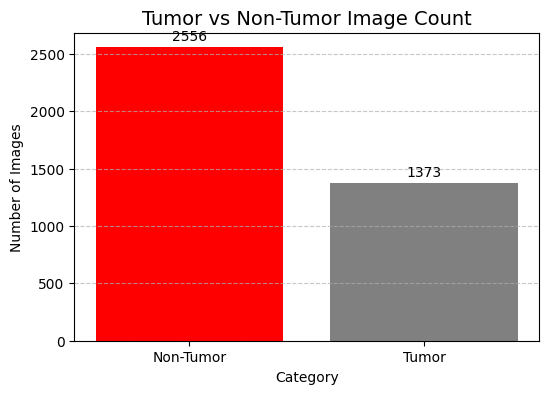

In [9]:
plt.figure(figsize=(6,4))
bars = plt.bar(counts.index, counts.values, color=["red", "gray"])
plt.title("Tumor vs Non-Tumor Image Count", fontsize=14)
plt.xlabel("Category")
plt.ylabel("Number of Images")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.bar_label(bars, padding=3)
plt.show()

### 2.2 Preprocessing

In [10]:
IMG_SIZE = 128   
def process_image(image_path, mask_path, img_size=IMG_SIZE):
    # Load image
    image = load_img(image_path, target_size=(img_size, img_size))
    image = img_to_array(image) / 255.0  # Normalize
    
    # Load mask (grayscale)
    mask = load_img(mask_path, target_size=(img_size, img_size), color_mode="grayscale")
    mask = img_to_array(mask)
    
    # Ensure mask is binary (0 or 1)
    mask = mask / 255.0
    mask = np.where(mask > 0.5, 1, 0)
    
    return image.astype(np.float32), mask.astype(np.float32)

In [11]:
images = []
masks = []

for img_path, msk_path in zip(image_paths, mask_paths):
    img, msk = process_image(img_path, msk_path)
    images.append(img)
    masks.append(msk)

images = np.array(images)
masks = np.array(masks)

print("Images shape:", images.shape)
print("Masks shape:", masks.shape)

Images shape: (3929, 128, 128, 3)
Masks shape: (3929, 128, 128, 1)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    images, masks, test_size=0.2, random_state=42
)

print("Train:", X_train.shape, y_train.shape)
print("Test: ", X_test.shape, y_test.shape)

Train: (3143, 128, 128, 3) (3143, 128, 128, 1)
Test:  (786, 128, 128, 3) (786, 128, 128, 1)


In [13]:
def visualize_samples(images, masks, n_samples=4):
    """
    Show random tumor and non-tumor MRI images with their masks.
    """
    tumor_indices = []
    non_tumor_indices = []

    # Separate indices for tumor and non-tumor
    for i in range(len(masks)):
        if np.max(masks[i]) > 0:      # Tumor present
            tumor_indices.append(i)
        else:                         # No tumor
            non_tumor_indices.append(i)

    # Choose random samples
    tumor_samples = random.sample(tumor_indices, min(n_samples, len(tumor_indices)))
    non_tumor_samples = random.sample(non_tumor_indices, min(n_samples, len(non_tumor_indices)))

    # Plot
    plt.figure(figsize=(12, 8))
    for i, idx in enumerate(tumor_samples):
        plt.subplot(2, n_samples, i+1)
        plt.imshow(images[idx])
        plt.imshow(masks[idx].squeeze(), cmap="Reds", alpha=0.4)
        plt.title("Tumor")
        plt.axis("off")

    for i, idx in enumerate(non_tumor_samples):
        plt.subplot(2, n_samples, i + 1 + n_samples)
        plt.imshow(images[idx])
        plt.imshow(masks[idx].squeeze(), cmap="Reds", alpha=0.3)
        plt.title("No Tumor")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

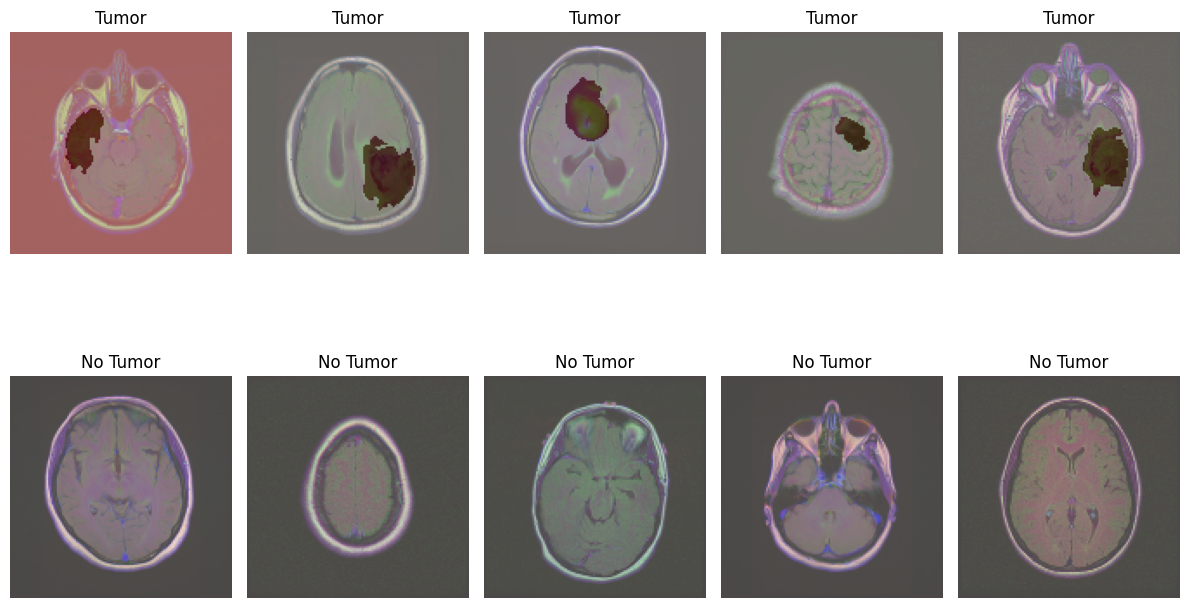

In [14]:
visualize_samples(X_test, y_test, n_samples=5)

In [15]:
# Augmentation configurations
data_gen_args = dict(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create ImageDataGenerator for both images and masks
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Same seed to ensure images and masks are augmented equally
seed = 42
batch_size = 16

image_generator = image_datagen.flow(X_train, batch_size=batch_size, seed=seed)
mask_generator = mask_datagen.flow(y_train, batch_size=batch_size, seed=seed)



In [16]:
def train_gen(image_gen, mask_gen):
    while True:
        img_batch = next(image_gen)
        mask_batch = next(mask_gen)

        yield (img_batch, mask_batch)

train_generator = train_gen(image_generator, mask_generator)

## 3.Model Definition

### 3.1 U-Net Architecture

In [17]:
def conv_block(x, filters, kernel_size=3, batch_norm=True, dropout=0.0):
    x = layers.Conv2D(filters, kernel_size, padding='same', kernel_initializer='he_normal')(x)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(filters, kernel_size, padding='same', kernel_initializer='he_normal')(x)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    if dropout and dropout > 0.0:
        x = layers.Dropout(dropout)(x)
    return x

def encoder_block(x, filters, pool=True, pool_size=(2,2), dropout=0.0):
    c = conv_block(x, filters, dropout=dropout)
    if pool:
        p = layers.MaxPooling2D(pool_size)(c)
        return c, p
    else:
        return c

def decoder_block(x, skip, filters):
    x = layers.Conv2DTranspose(filters, (2,2), strides=(2,2), padding='same')(x)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters)
    return x

def build_unet(input_shape=(IMG_SIZE, IMG_SIZE, 3), out_channels=1, base_filters=32, dropout_rate=0.1):
    inputs = layers.Input(shape=input_shape)
    
    # Encoder
    c1, p1 = encoder_block(inputs, base_filters, pool=True, dropout=dropout_rate)      # 32
    c2, p2 = encoder_block(p1, base_filters*2, pool=True, dropout=dropout_rate)        # 64
    c3, p3 = encoder_block(p2, base_filters*4, pool=True, dropout=dropout_rate)        # 128
    c4, p4 = encoder_block(p3, base_filters*8, pool=True, dropout=dropout_rate)        # 256
    
    # Bottleneck
    b = conv_block(p4, base_filters*16, batch_norm=True, dropout=dropout_rate)         # 512

    # Decoder
    d1 = decoder_block(b, c4, base_filters*8)
    d2 = decoder_block(d1, c3, base_filters*4)
    d3 = decoder_block(d2, c2, base_filters*2)
    d4 = decoder_block(d3, c1, base_filters)
    
    # Output
    if out_channels == 1:
        outputs = layers.Conv2D(1, (1,1), activation='sigmoid')(d4)
    else:
        outputs = layers.Conv2D(out_channels, (1,1), activation='softmax')(d4)
    
    model = Model(inputs, outputs, name='UNet_Professional')
    return model


model = build_unet(input_shape=(IMG_SIZE, IMG_SIZE, 3), out_channels=1, base_filters=32, dropout_rate=0.1)
model.summary()

Model: "UNet_Professional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ activation_1[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ activation_3[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ dropout_1[0][0] 

 Total params: 7,771,873 (29.65 MB)

 Trainable params: 7,765,985 (29.62 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [18]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (
        tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth
    )

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dl = dice_loss(y_true, y_pred)
    return bce + dl

def iou_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    total = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    union = total - intersection
    return (intersection + smooth) / (union + smooth)

### 3.2 Compile Model

In [19]:
#  Compile Model
LEARNING_RATE = 1e-4
model.compile(optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
              loss=bce_dice_loss,
              metrics=[dice_coef, iou_coef, 'accuracy'])



In [20]:
#  Callbacks
checkpoint_path = "/kaggle/working/checkpoints/unet_best.h5"
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', mode='min', verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
]

## 4. Model Training

In [21]:
#  Train Model with Augmentation
steps_per_epoch = len(X_train) // batch_size

history = model.fit(
    train_generator,
    validation_data=(X_test, y_test),
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    callbacks=callbacks
)


Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9367 - dice_coef: 0.0430 - iou_coef: 0.0222 - loss: 1.3332
Epoch 1: val_loss improved from None to 1.20108, saving model to /kaggle/working/checkpoints/unet_best.h5

Epoch 1: val_loss improved from None to 1.20108, saving model to /kaggle/working/checkpoints/unet_best.h5


196/196 ━━━━━━━━━━━━━━━━━━━━ 811s 4s/step - accuracy: 0.9688 - dice_coef: 0.0589 - iou_coef: 0.0307 - loss: 1.2200 - val_accuracy: 0.9903 - val_dice_coef: 0.0378 - val_iou_coef: 0.0193 - val_loss: 1.2011 - learning_rate: 1.0000e-04
Epoch 2/50
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9863 - dice_coef: 0.0877 - iou_coef: 0.0464 - loss: 1.0808
Epoch 2: val_loss improved from 1.20108 to 1.08519, saving model to /kaggle/working/checkpoints/unet_best.h5

Epoch 2: val_loss improved from 1.20108 to 1.08519, saving model to /kaggle/working/checkpoints/unet_best.h5


196/196 ━━━━━━━━━━━━━━━━━━━━ 756s 4s/step - accuracy: 0.9875 - dice_coef: 0.0977 - iou_coef: 0.0519 - loss: 1.0564 - val_accuracy: 0.9801 - val_dice_coef: 0.0977 - val_iou_coef: 0.0516 - val_loss: 1.0852 - learning_rate: 1.0000e-04
Epoch 3/50
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9877 - dice_coef: 0.1243 - iou_coef: 0.0674 - loss: 0.9991
Epoch 3: val_loss improved from 1.08519 to 0.98532, saving model to /kaggle/working/checkpoints/unet_best.h5

Epoch 3: val_loss improved from 1.08519 to 0.98532, saving model to /kaggle/working/checkpoints/unet_best.h5


196/196 ━━━━━━━━━━━━━━━━━━━━ 652s 3s/step - accuracy: 0.9885 - dice_coef: 0.1313 - iou_coef: 0.0713 - loss: 0.9844 - val_accuracy: 0.9921 - val_dice_coef: 0.1184 - val_iou_coef: 0.0633 - val_loss: 0.9853 - learning_rate: 1.0000e-04
Epoch 4/50
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9896 - dice_coef: 0.1654 - iou_coef: 0.0917 - loss: 0.9293
Epoch 4: val_loss improved from 0.98532 to 0.91066, saving model to /kaggle/working/checkpoints/unet_best.h5

Epoch 4: val_loss improved from 0.98532 to 0.91066, saving model to /kaggle/working/checkpoints/unet_best.h5


196/196 ━━━━━━━━━━━━━━━━━━━━ 626s 3s/step - accuracy: 0.9888 - dice_coef: 0.1750 - iou_coef: 0.0977 - loss: 0.9154 - val_accuracy: 0.9919 - val_dice_coef: 0.1686 - val_iou_coef: 0.0928 - val_loss: 0.9107 - learning_rate: 1.0000e-04
Epoch 5/50
Epoch 5/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9888 - dice_coef: 0.2097 - iou_coef: 0.1197 - loss: 0.8649
Epoch 5: val_loss improved from 0.91066 to 0.84222, saving model to /kaggle/working/checkpoints/unet_best.h5

Epoch 5: val_loss improved from 0.91066 to 0.84222, saving model to /kaggle/working/checkpoints/unet_best.h5


196/196 ━━━━━━━━━━━━━━━━━━━━ 634s 3s/step - accuracy: 0.9892 - dice_coef: 0.2225 - iou_coef: 0.1280 - loss: 0.8481 - val_accuracy: 0.9926 - val_dice_coef: 0.2184 - val_iou_coef: 0.1240 - val_loss: 0.8422 - learning_rate: 1.0000e-04
Epoch 6/50
Epoch 6/50
158/196 ━━━━━━━━━━━━━━━━━━━━ 1:55 3s/step - accuracy: 0.9898 - dice_coef: 0.2397 - iou_coef: 0.1400 - loss: 0.8182

KeyboardInterrupt: 

## 5. Performance Visualization

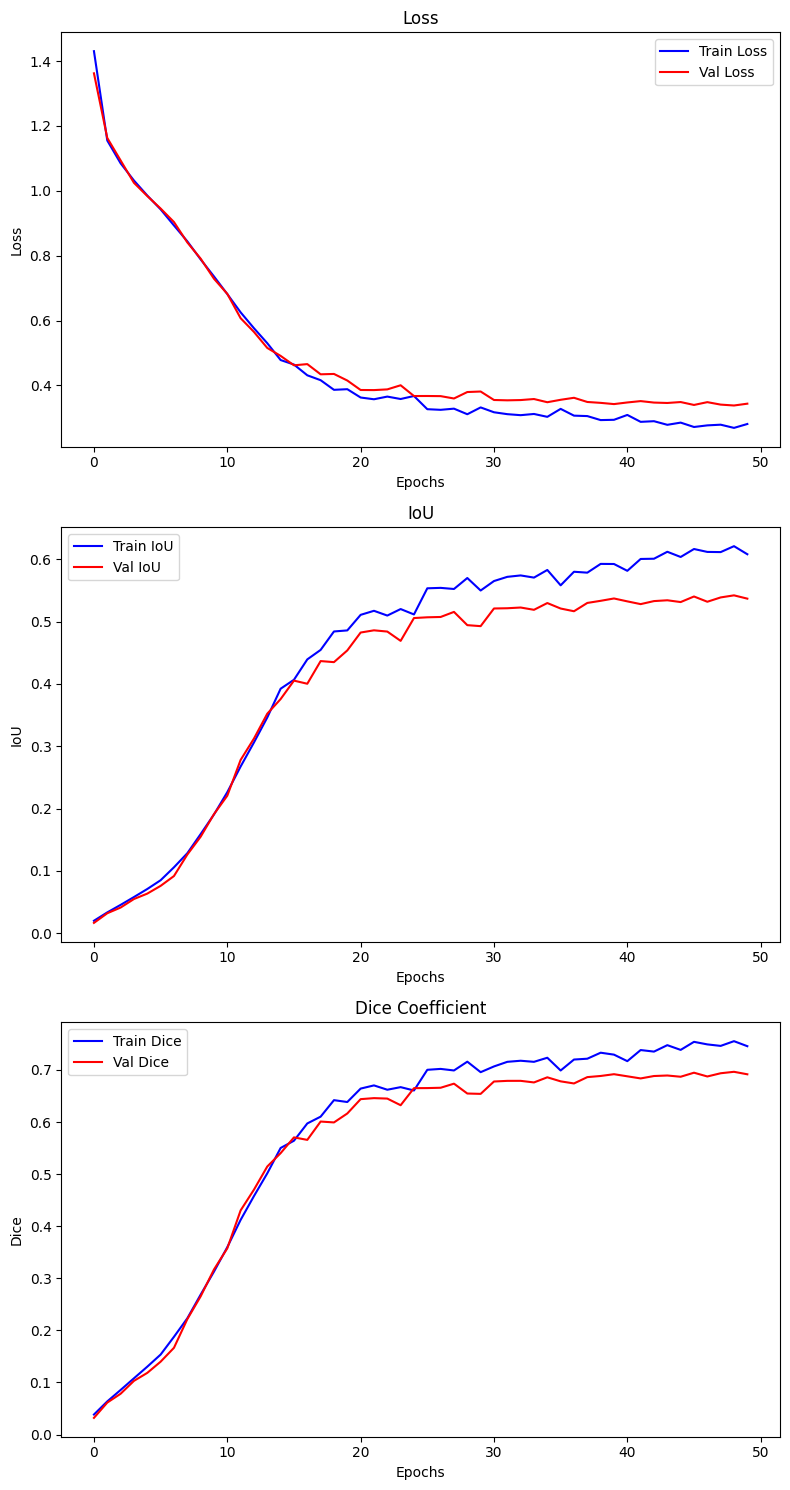

In [20]:
# Evaluation Visualization
plt.figure(figsize=(8, 15))

# --- Loss ---
plt.subplot(3, 1, 1)
plt.plot(history.history['loss'], 'b-', label='Train Loss')
plt.plot(history.history['val_loss'], 'r-', label='Val Loss')
plt.legend(loc='best')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# --- IoU ---
plt.subplot(3, 1, 2)
plt.plot(history.history['iou_coef'], 'b-', label='Train IoU')
plt.plot(history.history['val_iou_coef'], 'r-', label='Val IoU')
plt.legend(loc='best')
plt.title('IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')

# --- Dice Coefficient ---
plt.subplot(3, 1, 3)
plt.plot(history.history['dice_coef'], 'b-', label='Train Dice')
plt.plot(history.history['val_dice_coef'], 'r-', label='Val Dice')
plt.legend(loc='best')
plt.title('Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice')

plt.tight_layout()
plt.show()

## 6. Model Evaluation

In [21]:
BATCH_SIZE=16
# Define test data generator (no augmentation)
test_datagen = ImageDataGenerator()

# Create generator for test data
test_generator = test_datagen.flow(
    X_test, 
    y_test, 
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Evaluate model
results = model.evaluate(test_generator, steps=len(X_test) // BATCH_SIZE)

print(f" Test Loss: {results[0]:.4f}")
print(f" Test Dice Coefficient: {results[1]:.4f}")
print(f" Test IoU: {results[2]:.4f}")
print(f" Test Accuracy: {results[3]:.4f}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9946 - dice_coef: 0.7107 - iou_coef: 0.5715 - loss: 0.3206
 Test Loss: 0.3441
 Test Dice Coefficient: 0.6895
 Test IoU: 0.5445
 Test Accuracy: 0.9944


## 7.Tumor Presence Detection

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


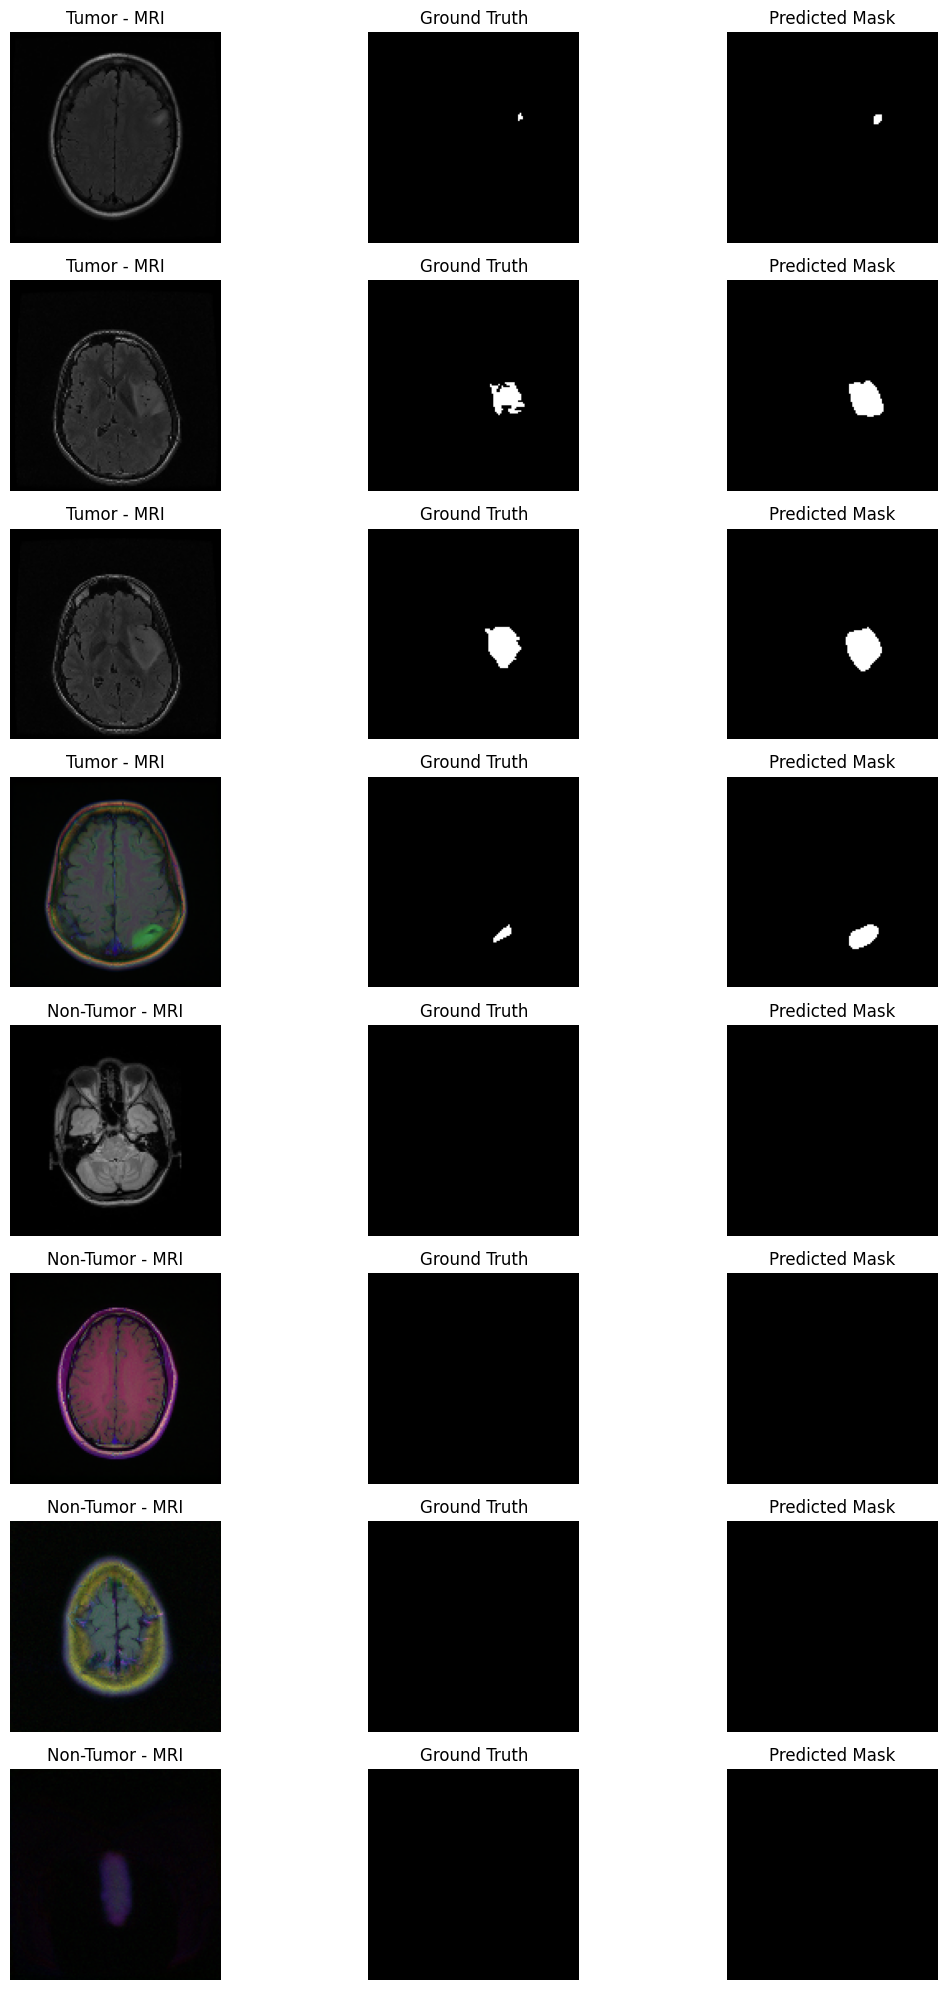

In [22]:
def visualize_predictions(model, X_test, y_test, num_per_class=4):
    """
    Visualize a balanced set of tumor and non-tumor samples with 
    original MRI, ground truth mask, and predicted mask.
    """
    # Flatten masks to detect presence of tumor (any pixel > 0)
    tumor_indices = [i for i in range(len(y_test)) if np.any(y_test[i] > 0)]
    non_tumor_indices = [i for i in range(len(y_test)) if not np.any(y_test[i] > 0)]

    # Ensure enough samples exist in both categories
    tumor_indices = random.sample(tumor_indices, min(num_per_class, len(tumor_indices)))
    non_tumor_indices = random.sample(non_tumor_indices, min(num_per_class, len(non_tumor_indices)))

    selected_indices = tumor_indices + non_tumor_indices
    total_samples = len(selected_indices)

    plt.figure(figsize=(12, total_samples * 2.5))

    for i, idx in enumerate(selected_indices):
        image = X_test[idx]
        true_mask = y_test[idx]

        # Predict mask
        pred_mask = model.predict(np.expand_dims(image, axis=0))[0]
        pred_mask = (pred_mask > 0.5).astype(np.uint8)

        # Titles
        label = "Tumor" if np.any(true_mask > 0) else "Non-Tumor"

        # Original MRI
        plt.subplot(total_samples, 3, i*3 + 1)
        plt.imshow(image)
        plt.title(f"{label} - MRI")
        plt.axis("off")

        # Ground truth mask
        plt.subplot(total_samples, 3, i*3 + 2)
        plt.imshow(true_mask.squeeze(), cmap='gray')
        plt.title("Ground Truth")
        plt.axis("off")

        # Predicted mask
        plt.subplot(total_samples, 3, i*3 + 3)
        plt.imshow(pred_mask.squeeze(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Run visualization 
visualize_predictions(model, X_test, y_test, num_per_class=4)

### 7.1 Evaluate Tumor Detection Accuracy

In [23]:
from tqdm import tqdm

correct, incorrect = 0, 0

# Loop through test set
for i in tqdm(range(len(X_test)), desc="Evaluating tumor detection"):
    # Get image and true mask
    img = np.expand_dims(X_test[i], axis=0)
    true_mask = y_test[i].squeeze()

    # Predict mask
    pred = model.predict(img, verbose=0)
    pred_mask = np.squeeze(pred) > 0.5

    # Check if both masks indicate tumor presence
    has_tumor_true = true_mask.any()
    has_tumor_pred = pred_mask.any()

    # Compare prediction
    is_correct = has_tumor_true == has_tumor_pred
    print(f"Prediction {i}: {' Correct' if is_correct else ' Incorrect'}")

    if is_correct:
        correct += 1
    else:
        incorrect += 1

# Final accuracy for tumor presence detection
accuracy = correct / (correct + incorrect)
print("\n Tumor Presence Detection Summary")
print(f"✔ Correct: {correct}")
print(f"✖ Incorrect: {incorrect}")
print(f" Accuracy: {accuracy * 100:.2f}%")


Evaluating tumor detection:   0%|          | 2/786 [00:00<01:10, 11.12it/s]

Prediction 0:  Correct
Prediction 1:  Correct
Prediction 2:  Correct


Evaluating tumor detection:   1%|          | 6/786 [00:00<01:09, 11.16it/s]

Prediction 3:  Correct
Prediction 4:  Correct
Prediction 5:  Correct


Evaluating tumor detection:   1%|          | 8/786 [00:00<01:11, 10.91it/s]

Prediction 6:  Correct
Prediction 7:  Correct
Prediction 8:  Correct


Evaluating tumor detection:   2%|▏         | 12/786 [00:01<01:12, 10.67it/s]

Prediction 9:  Correct
Prediction 10:  Correct
Prediction 11:  Correct


Evaluating tumor detection:   2%|▏         | 14/786 [00:01<01:12, 10.61it/s]

Prediction 12:  Correct
Prediction 13:  Correct
Prediction 14:  Correct


Evaluating tumor detection:   2%|▏         | 18/786 [00:01<01:12, 10.53it/s]

Prediction 15:  Correct
Prediction 16:  Correct
Prediction 17:  Correct


Evaluating tumor detection:   3%|▎         | 20/786 [00:01<01:12, 10.63it/s]

Prediction 18:  Correct
Prediction 19:  Correct
Prediction 20:  Correct


Evaluating tumor detection:   3%|▎         | 24/786 [00:02<01:12, 10.55it/s]

Prediction 21:  Incorrect
Prediction 22:  Correct
Prediction 23:  Correct


Evaluating tumor detection:   3%|▎         | 26/786 [00:02<01:13, 10.37it/s]

Prediction 24:  Correct
Prediction 25:  Correct
Prediction 26:  Correct


Evaluating tumor detection:   4%|▍         | 30/786 [00:02<01:12, 10.44it/s]

Prediction 27:  Correct
Prediction 28:  Correct
Prediction 29:  Correct


Evaluating tumor detection:   4%|▍         | 32/786 [00:03<01:12, 10.45it/s]

Prediction 30:  Correct
Prediction 31:  Correct
Prediction 32:  Incorrect


Evaluating tumor detection:   5%|▍         | 36/786 [00:03<01:10, 10.58it/s]

Prediction 33:  Incorrect
Prediction 34:  Correct
Prediction 35:  Correct


Evaluating tumor detection:   5%|▍         | 38/786 [00:03<01:11, 10.50it/s]

Prediction 36:  Correct
Prediction 37:  Correct
Prediction 38:  Correct


Evaluating tumor detection:   5%|▌         | 42/786 [00:03<01:11, 10.38it/s]

Prediction 39:  Correct
Prediction 40:  Incorrect
Prediction 41:  Correct


Evaluating tumor detection:   6%|▌         | 44/786 [00:04<01:13, 10.07it/s]

Prediction 42:  Correct
Prediction 43:  Correct


Evaluating tumor detection:   6%|▌         | 46/786 [00:04<01:13, 10.12it/s]

Prediction 44:  Correct
Prediction 45:  Correct
Prediction 46:  Correct


Evaluating tumor detection:   6%|▋         | 50/786 [00:04<01:11, 10.29it/s]

Prediction 47:  Correct
Prediction 48:  Correct
Prediction 49:  Correct


Evaluating tumor detection:   7%|▋         | 52/786 [00:04<01:10, 10.43it/s]

Prediction 50:  Correct
Prediction 51:  Correct
Prediction 52:  Correct


Evaluating tumor detection:   7%|▋         | 56/786 [00:05<01:08, 10.62it/s]

Prediction 53:  Correct
Prediction 54:  Correct
Prediction 55:  Correct


Evaluating tumor detection:   7%|▋         | 58/786 [00:05<01:08, 10.60it/s]

Prediction 56:  Correct
Prediction 57:  Correct
Prediction 58:  Correct


Evaluating tumor detection:   8%|▊         | 62/786 [00:05<01:10, 10.31it/s]

Prediction 59:  Correct
Prediction 60:  Correct
Prediction 61:  Correct


Evaluating tumor detection:   8%|▊         | 64/786 [00:06<01:08, 10.48it/s]

Prediction 62:  Correct
Prediction 63:  Correct
Prediction 64:  Correct


Evaluating tumor detection:   9%|▊         | 68/786 [00:06<01:08, 10.53it/s]

Prediction 65:  Correct
Prediction 66:  Correct
Prediction 67:  Correct


Evaluating tumor detection:   9%|▉         | 70/786 [00:06<01:08, 10.51it/s]

Prediction 68:  Correct
Prediction 69:  Incorrect
Prediction 70:  Correct


Evaluating tumor detection:   9%|▉         | 74/786 [00:07<01:07, 10.60it/s]

Prediction 71:  Correct
Prediction 72:  Correct
Prediction 73:  Correct


Evaluating tumor detection:  10%|▉         | 76/786 [00:07<01:06, 10.70it/s]

Prediction 74:  Correct
Prediction 75:  Correct
Prediction 76:  Correct


Evaluating tumor detection:  10%|█         | 80/786 [00:07<01:05, 10.85it/s]

Prediction 77:  Correct
Prediction 78:  Incorrect
Prediction 79:  Correct


Evaluating tumor detection:  10%|█         | 82/786 [00:07<01:04, 10.97it/s]

Prediction 80:  Correct
Prediction 81:  Correct
Prediction 82:  Correct


Evaluating tumor detection:  11%|█         | 86/786 [00:08<01:03, 10.94it/s]

Prediction 83:  Correct
Prediction 84:  Correct
Prediction 85:  Incorrect


Evaluating tumor detection:  11%|█         | 88/786 [00:08<01:04, 10.88it/s]

Prediction 86:  Correct
Prediction 87:  Correct
Prediction 88:  Correct


Evaluating tumor detection:  12%|█▏        | 92/786 [00:08<01:04, 10.79it/s]

Prediction 89:  Correct
Prediction 90:  Correct
Prediction 91:  Correct


Evaluating tumor detection:  12%|█▏        | 94/786 [00:08<01:04, 10.75it/s]

Prediction 92:  Incorrect
Prediction 93:  Correct
Prediction 94:  Correct


Evaluating tumor detection:  12%|█▏        | 96/786 [00:09<01:04, 10.71it/s]

Prediction 95:  Correct
Prediction 96:  Correct


Evaluating tumor detection:  13%|█▎        | 100/786 [00:09<01:06, 10.33it/s]

Prediction 97:  Correct
Prediction 98:  Incorrect
Prediction 99:  Incorrect


Evaluating tumor detection:  13%|█▎        | 102/786 [00:09<01:04, 10.52it/s]

Prediction 100:  Correct
Prediction 101:  Correct
Prediction 102:  Correct


Evaluating tumor detection:  13%|█▎        | 106/786 [00:10<01:02, 10.85it/s]

Prediction 103:  Correct
Prediction 104:  Correct
Prediction 105:  Correct


Evaluating tumor detection:  14%|█▎        | 108/786 [00:10<01:01, 10.94it/s]

Prediction 106:  Correct
Prediction 107:  Correct
Prediction 108:  Correct


Evaluating tumor detection:  14%|█▍        | 112/786 [00:10<01:01, 10.99it/s]

Prediction 109:  Incorrect
Prediction 110:  Correct
Prediction 111:  Correct


Evaluating tumor detection:  15%|█▍        | 114/786 [00:10<01:01, 10.99it/s]

Prediction 112:  Correct
Prediction 113:  Correct
Prediction 114:  Correct


Evaluating tumor detection:  15%|█▌        | 118/786 [00:11<01:01, 10.91it/s]

Prediction 115:  Correct
Prediction 116:  Correct
Prediction 117:  Correct


Evaluating tumor detection:  15%|█▌        | 120/786 [00:11<01:00, 10.93it/s]

Prediction 118:  Correct
Prediction 119:  Incorrect
Prediction 120:  Correct


Evaluating tumor detection:  16%|█▌        | 124/786 [00:11<01:00, 10.96it/s]

Prediction 121:  Correct
Prediction 122:  Correct
Prediction 123:  Correct


Evaluating tumor detection:  16%|█▌        | 126/786 [00:11<01:00, 10.94it/s]

Prediction 124:  Correct
Prediction 125:  Incorrect
Prediction 126:  Correct


Evaluating tumor detection:  17%|█▋        | 130/786 [00:12<00:59, 10.96it/s]

Prediction 127:  Correct
Prediction 128:  Correct
Prediction 129:  Correct


Evaluating tumor detection:  17%|█▋        | 132/786 [00:12<00:59, 10.96it/s]

Prediction 130:  Correct
Prediction 131:  Correct
Prediction 132:  Correct


Evaluating tumor detection:  17%|█▋        | 136/786 [00:12<00:59, 10.98it/s]

Prediction 133:  Correct
Prediction 134:  Correct
Prediction 135:  Correct


Evaluating tumor detection:  18%|█▊        | 138/786 [00:12<00:59, 10.90it/s]

Prediction 136:  Correct
Prediction 137:  Incorrect
Prediction 138:  Correct


Evaluating tumor detection:  18%|█▊        | 142/786 [00:13<00:58, 10.92it/s]

Prediction 139:  Correct
Prediction 140:  Correct
Prediction 141:  Correct


Evaluating tumor detection:  18%|█▊        | 144/786 [00:13<00:59, 10.84it/s]

Prediction 142:  Correct
Prediction 143:  Incorrect
Prediction 144:  Correct


Evaluating tumor detection:  19%|█▉        | 148/786 [00:13<01:00, 10.61it/s]

Prediction 145:  Correct
Prediction 146:  Correct
Prediction 147:  Correct


Evaluating tumor detection:  19%|█▉        | 150/786 [00:14<01:00, 10.59it/s]

Prediction 148:  Correct
Prediction 149:  Correct
Prediction 150:  Correct


Evaluating tumor detection:  20%|█▉        | 154/786 [00:14<00:59, 10.70it/s]

Prediction 151:  Correct
Prediction 152:  Correct
Prediction 153:  Correct


Evaluating tumor detection:  20%|█▉        | 156/786 [00:14<01:00, 10.47it/s]

Prediction 154:  Incorrect
Prediction 155:  Correct


Evaluating tumor detection:  20%|██        | 158/786 [00:14<01:00, 10.37it/s]

Prediction 156:  Correct
Prediction 157:  Correct
Prediction 158:  Correct


Evaluating tumor detection:  21%|██        | 162/786 [00:15<00:58, 10.74it/s]

Prediction 159:  Correct
Prediction 160:  Correct
Prediction 161:  Correct


Evaluating tumor detection:  21%|██        | 164/786 [00:15<00:57, 10.85it/s]

Prediction 162:  Incorrect
Prediction 163:  Correct
Prediction 164:  Correct


Evaluating tumor detection:  21%|██        | 166/786 [00:15<00:57, 10.87it/s]

Prediction 165:  Correct
Prediction 166:  Correct


Evaluating tumor detection:  22%|██▏       | 170/786 [00:15<00:58, 10.52it/s]

Prediction 167:  Correct
Prediction 168:  Correct
Prediction 169:  Incorrect


Evaluating tumor detection:  22%|██▏       | 172/786 [00:16<00:58, 10.55it/s]

Prediction 170:  Correct
Prediction 171:  Correct
Prediction 172:  Correct


Evaluating tumor detection:  22%|██▏       | 174/786 [00:16<00:57, 10.58it/s]

Prediction 173:  Correct
Prediction 174:  Correct
Prediction 175:  Correct


Evaluating tumor detection:  23%|██▎       | 178/786 [00:16<00:57, 10.52it/s]

Prediction 176:  Correct
Prediction 177:  Correct
Prediction 178:  Incorrect


Evaluating tumor detection:  23%|██▎       | 182/786 [00:17<00:57, 10.52it/s]

Prediction 179:  Correct
Prediction 180:  Correct
Prediction 181:  Correct


Evaluating tumor detection:  23%|██▎       | 184/786 [00:17<00:57, 10.55it/s]

Prediction 182:  Correct
Prediction 183:  Correct
Prediction 184:  Correct


Evaluating tumor detection:  24%|██▍       | 188/786 [00:17<00:56, 10.57it/s]

Prediction 185:  Correct
Prediction 186:  Correct
Prediction 187:  Correct


Evaluating tumor detection:  24%|██▍       | 190/786 [00:17<00:57, 10.43it/s]

Prediction 188:  Incorrect
Prediction 189:  Correct
Prediction 190:  Correct


Evaluating tumor detection:  25%|██▍       | 194/786 [00:18<00:56, 10.52it/s]

Prediction 191:  Correct
Prediction 192:  Correct
Prediction 193:  Correct


Evaluating tumor detection:  25%|██▍       | 196/786 [00:18<00:56, 10.51it/s]

Prediction 194:  Correct
Prediction 195:  Correct
Prediction 196:  Correct


Evaluating tumor detection:  25%|██▌       | 200/786 [00:18<00:55, 10.50it/s]

Prediction 197:  Correct
Prediction 198:  Correct
Prediction 199:  Correct


Evaluating tumor detection:  26%|██▌       | 202/786 [00:18<00:55, 10.58it/s]

Prediction 200:  Correct
Prediction 201:  Correct
Prediction 202:  Correct


Evaluating tumor detection:  26%|██▌       | 206/786 [00:19<00:55, 10.39it/s]

Prediction 203:  Correct
Prediction 204:  Correct
Prediction 205:  Correct


Evaluating tumor detection:  26%|██▋       | 208/786 [00:19<00:55, 10.44it/s]

Prediction 206:  Correct
Prediction 207:  Correct
Prediction 208:  Correct


Evaluating tumor detection:  27%|██▋       | 212/786 [00:19<00:55, 10.32it/s]

Prediction 209:  Correct
Prediction 210:  Correct
Prediction 211:  Correct


Evaluating tumor detection:  27%|██▋       | 214/786 [00:20<00:55, 10.35it/s]

Prediction 212:  Correct
Prediction 213:  Correct
Prediction 214:  Correct


Evaluating tumor detection:  28%|██▊       | 218/786 [00:20<00:52, 10.77it/s]

Prediction 215:  Correct
Prediction 216:  Correct
Prediction 217:  Correct


Evaluating tumor detection:  28%|██▊       | 220/786 [00:20<00:51, 10.90it/s]

Prediction 218:  Correct
Prediction 219:  Correct
Prediction 220:  Correct


Evaluating tumor detection:  28%|██▊       | 224/786 [00:21<00:51, 10.97it/s]

Prediction 221:  Correct
Prediction 222:  Correct
Prediction 223:  Correct


Evaluating tumor detection:  29%|██▉       | 226/786 [00:21<00:51, 10.96it/s]

Prediction 224:  Correct
Prediction 225:  Correct
Prediction 226:  Correct


Evaluating tumor detection:  29%|██▉       | 230/786 [00:21<00:52, 10.67it/s]

Prediction 227:  Correct
Prediction 228:  Correct
Prediction 229:  Correct


Evaluating tumor detection:  30%|██▉       | 232/786 [00:21<00:51, 10.67it/s]

Prediction 230:  Correct
Prediction 231:  Correct
Prediction 232:  Incorrect


Evaluating tumor detection:  30%|███       | 236/786 [00:22<00:51, 10.76it/s]

Prediction 233:  Correct
Prediction 234:  Correct
Prediction 235:  Correct


Evaluating tumor detection:  30%|███       | 238/786 [00:22<00:50, 10.82it/s]

Prediction 236:  Correct
Prediction 237:  Correct
Prediction 238:  Correct


Evaluating tumor detection:  31%|███       | 242/786 [00:22<00:49, 10.92it/s]

Prediction 239:  Correct
Prediction 240:  Correct
Prediction 241:  Correct


Evaluating tumor detection:  31%|███       | 244/786 [00:22<00:50, 10.82it/s]

Prediction 242:  Correct
Prediction 243:  Correct
Prediction 244:  Correct


Evaluating tumor detection:  32%|███▏      | 248/786 [00:23<00:49, 10.84it/s]

Prediction 245:  Correct
Prediction 246:  Correct
Prediction 247:  Correct


Evaluating tumor detection:  32%|███▏      | 250/786 [00:23<00:49, 10.77it/s]

Prediction 248:  Correct
Prediction 249:  Correct
Prediction 250:  Correct


Evaluating tumor detection:  32%|███▏      | 254/786 [00:23<00:49, 10.73it/s]

Prediction 251:  Correct
Prediction 252:  Correct
Prediction 253:  Correct


Evaluating tumor detection:  33%|███▎      | 256/786 [00:24<00:49, 10.76it/s]

Prediction 254:  Incorrect
Prediction 255:  Correct
Prediction 256:  Correct


Evaluating tumor detection:  33%|███▎      | 260/786 [00:24<00:48, 10.74it/s]

Prediction 257:  Correct
Prediction 258:  Correct
Prediction 259:  Correct


Evaluating tumor detection:  33%|███▎      | 262/786 [00:24<00:48, 10.80it/s]

Prediction 260:  Correct
Prediction 261:  Correct
Prediction 262:  Correct


Evaluating tumor detection:  34%|███▍      | 266/786 [00:24<00:48, 10.66it/s]

Prediction 263:  Correct
Prediction 264:  Correct
Prediction 265:  Correct


Evaluating tumor detection:  34%|███▍      | 268/786 [00:25<00:49, 10.53it/s]

Prediction 266:  Correct
Prediction 267:  Correct
Prediction 268:  Incorrect


Evaluating tumor detection:  35%|███▍      | 272/786 [00:25<00:48, 10.49it/s]

Prediction 269:  Correct
Prediction 270:  Correct
Prediction 271:  Correct


Evaluating tumor detection:  35%|███▍      | 274/786 [00:25<00:50, 10.18it/s]

Prediction 272:  Correct
Prediction 273:  Correct
Prediction 274:  Correct


Evaluating tumor detection:  35%|███▌      | 278/786 [00:26<00:47, 10.65it/s]

Prediction 275:  Correct
Prediction 276:  Incorrect
Prediction 277:  Correct


Evaluating tumor detection:  36%|███▌      | 280/786 [00:26<00:46, 10.90it/s]

Prediction 278:  Correct
Prediction 279:  Correct
Prediction 280:  Correct


Evaluating tumor detection:  36%|███▌      | 284/786 [00:26<00:45, 10.98it/s]

Prediction 281:  Correct
Prediction 282:  Incorrect
Prediction 283:  Correct


Evaluating tumor detection:  36%|███▋      | 286/786 [00:26<00:45, 10.89it/s]

Prediction 284:  Correct
Prediction 285:  Correct
Prediction 286:  Correct


Evaluating tumor detection:  37%|███▋      | 290/786 [00:27<00:45, 10.79it/s]

Prediction 287:  Correct
Prediction 288:  Correct
Prediction 289:  Correct


Evaluating tumor detection:  37%|███▋      | 292/786 [00:27<00:45, 10.82it/s]

Prediction 290:  Correct
Prediction 291:  Correct
Prediction 292:  Correct


Evaluating tumor detection:  38%|███▊      | 296/786 [00:27<00:46, 10.52it/s]

Prediction 293:  Correct
Prediction 294:  Incorrect
Prediction 295:  Incorrect


Evaluating tumor detection:  38%|███▊      | 298/786 [00:27<00:46, 10.51it/s]

Prediction 296:  Correct
Prediction 297:  Correct
Prediction 298:  Correct


Evaluating tumor detection:  38%|███▊      | 302/786 [00:28<00:45, 10.66it/s]

Prediction 299:  Correct
Prediction 300:  Correct
Prediction 301:  Correct


Evaluating tumor detection:  39%|███▊      | 304/786 [00:28<00:45, 10.56it/s]

Prediction 302:  Incorrect
Prediction 303:  Correct
Prediction 304:  Correct


Evaluating tumor detection:  39%|███▉      | 308/786 [00:28<00:45, 10.59it/s]

Prediction 305:  Correct
Prediction 306:  Correct
Prediction 307:  Correct


Evaluating tumor detection:  39%|███▉      | 310/786 [00:29<00:44, 10.70it/s]

Prediction 308:  Correct
Prediction 309:  Correct
Prediction 310:  Correct


Evaluating tumor detection:  40%|███▉      | 312/786 [00:29<00:44, 10.68it/s]

Prediction 311:  Correct
Prediction 312:  Correct


Evaluating tumor detection:  40%|████      | 316/786 [00:29<00:44, 10.59it/s]

Prediction 313:  Correct
Prediction 314:  Correct
Prediction 315:  Incorrect


Evaluating tumor detection:  40%|████      | 318/786 [00:29<00:44, 10.57it/s]

Prediction 316:  Correct
Prediction 317:  Incorrect
Prediction 318:  Correct


Evaluating tumor detection:  41%|████      | 322/786 [00:30<00:42, 10.84it/s]

Prediction 319:  Correct
Prediction 320:  Correct
Prediction 321:  Correct


Evaluating tumor detection:  41%|████      | 324/786 [00:30<00:42, 10.89it/s]

Prediction 322:  Correct
Prediction 323:  Correct
Prediction 324:  Correct


Evaluating tumor detection:  42%|████▏     | 328/786 [00:30<00:42, 10.72it/s]

Prediction 325:  Correct
Prediction 326:  Correct
Prediction 327:  Incorrect


Evaluating tumor detection:  42%|████▏     | 330/786 [00:30<00:42, 10.80it/s]

Prediction 328:  Correct
Prediction 329:  Correct
Prediction 330:  Correct


Evaluating tumor detection:  42%|████▏     | 334/786 [00:31<00:41, 10.89it/s]

Prediction 331:  Correct
Prediction 332:  Correct
Prediction 333:  Correct


Evaluating tumor detection:  43%|████▎     | 336/786 [00:31<00:41, 10.86it/s]

Prediction 334:  Correct
Prediction 335:  Correct
Prediction 336:  Correct


Evaluating tumor detection:  43%|████▎     | 340/786 [00:31<00:41, 10.77it/s]

Prediction 337:  Correct
Prediction 338:  Correct
Prediction 339:  Incorrect


Evaluating tumor detection:  44%|████▎     | 342/786 [00:32<00:41, 10.79it/s]

Prediction 340:  Correct
Prediction 341:  Incorrect
Prediction 342:  Correct


Evaluating tumor detection:  44%|████▍     | 346/786 [00:32<00:39, 11.06it/s]

Prediction 343:  Correct
Prediction 344:  Correct
Prediction 345:  Correct


Evaluating tumor detection:  44%|████▍     | 348/786 [00:32<00:39, 11.01it/s]

Prediction 346:  Correct
Prediction 347:  Correct
Prediction 348:  Incorrect


Evaluating tumor detection:  45%|████▍     | 350/786 [00:32<00:40, 10.87it/s]

Prediction 349:  Correct
Prediction 350:  Correct


Evaluating tumor detection:  45%|████▌     | 354/786 [00:33<00:41, 10.41it/s]

Prediction 351:  Correct
Prediction 352:  Correct
Prediction 353:  Correct


Evaluating tumor detection:  45%|████▌     | 356/786 [00:33<00:41, 10.42it/s]

Prediction 354:  Correct
Prediction 355:  Correct
Prediction 356:  Correct


Evaluating tumor detection:  46%|████▌     | 360/786 [00:33<00:40, 10.63it/s]

Prediction 357:  Correct
Prediction 358:  Incorrect
Prediction 359:  Correct


Evaluating tumor detection:  46%|████▌     | 362/786 [00:33<00:40, 10.46it/s]

Prediction 360:  Correct
Prediction 361:  Correct
Prediction 362:  Correct


Evaluating tumor detection:  47%|████▋     | 366/786 [00:34<00:40, 10.47it/s]

Prediction 363:  Incorrect
Prediction 364:  Correct
Prediction 365:  Correct


Evaluating tumor detection:  47%|████▋     | 368/786 [00:34<00:40, 10.35it/s]

Prediction 366:  Correct
Prediction 367:  Incorrect
Prediction 368:  Correct


Evaluating tumor detection:  47%|████▋     | 372/786 [00:34<00:38, 10.77it/s]

Prediction 369:  Correct
Prediction 370:  Correct
Prediction 371:  Correct


Evaluating tumor detection:  48%|████▊     | 374/786 [00:35<00:38, 10.78it/s]

Prediction 372:  Incorrect
Prediction 373:  Correct
Prediction 374:  Correct


Evaluating tumor detection:  48%|████▊     | 378/786 [00:35<00:36, 11.03it/s]

Prediction 375:  Correct
Prediction 376:  Incorrect
Prediction 377:  Correct


Evaluating tumor detection:  48%|████▊     | 380/786 [00:35<00:37, 10.94it/s]

Prediction 378:  Correct
Prediction 379:  Correct


Evaluating tumor detection:  49%|████▊     | 382/786 [00:35<00:38, 10.60it/s]

Prediction 380:  Incorrect
Prediction 381:  Incorrect
Prediction 382:  Correct


Evaluating tumor detection:  49%|████▉     | 386/786 [00:36<00:37, 10.60it/s]

Prediction 383:  Correct
Prediction 384:  Correct
Prediction 385:  Correct


Evaluating tumor detection:  49%|████▉     | 388/786 [00:36<00:37, 10.67it/s]

Prediction 386:  Correct
Prediction 387:  Incorrect
Prediction 388:  Correct


Evaluating tumor detection:  50%|████▉     | 392/786 [00:36<00:36, 10.93it/s]

Prediction 389:  Correct
Prediction 390:  Correct
Prediction 391:  Correct


Evaluating tumor detection:  50%|█████     | 394/786 [00:36<00:36, 10.84it/s]

Prediction 392:  Correct
Prediction 393:  Correct
Prediction 394:  Correct


Evaluating tumor detection:  51%|█████     | 398/786 [00:37<00:35, 10.87it/s]

Prediction 395:  Incorrect
Prediction 396:  Correct
Prediction 397:  Correct


Evaluating tumor detection:  51%|█████     | 400/786 [00:37<00:35, 10.93it/s]

Prediction 398:  Correct
Prediction 399:  Correct
Prediction 400:  Correct


Evaluating tumor detection:  51%|█████▏    | 404/786 [00:37<00:35, 10.90it/s]

Prediction 401:  Correct
Prediction 402:  Incorrect
Prediction 403:  Correct


Evaluating tumor detection:  52%|█████▏    | 406/786 [00:38<00:34, 10.98it/s]

Prediction 404:  Correct
Prediction 405:  Incorrect
Prediction 406:  Correct


Evaluating tumor detection:  52%|█████▏    | 410/786 [00:38<00:34, 10.91it/s]

Prediction 407:  Correct
Prediction 408:  Correct
Prediction 409:  Correct


Evaluating tumor detection:  52%|█████▏    | 412/786 [00:38<00:34, 10.94it/s]

Prediction 410:  Correct
Prediction 411:  Correct
Prediction 412:  Correct


Evaluating tumor detection:  53%|█████▎    | 416/786 [00:38<00:34, 10.63it/s]

Prediction 413:  Correct
Prediction 414:  Correct
Prediction 415:  Correct


Evaluating tumor detection:  53%|█████▎    | 418/786 [00:39<00:34, 10.68it/s]

Prediction 416:  Correct
Prediction 417:  Correct
Prediction 418:  Correct


Evaluating tumor detection:  53%|█████▎    | 420/786 [00:39<00:34, 10.69it/s]

Prediction 419:  Correct
Prediction 420:  Correct
Prediction 421:  Correct


Evaluating tumor detection:  54%|█████▍    | 424/786 [00:39<00:34, 10.37it/s]

Prediction 422:  Correct
Prediction 423:  Correct
Prediction 424:  Correct


Evaluating tumor detection:  54%|█████▍    | 428/786 [00:40<00:33, 10.75it/s]

Prediction 425:  Correct
Prediction 426:  Correct
Prediction 427:  Correct


Evaluating tumor detection:  55%|█████▍    | 430/786 [00:40<00:32, 10.93it/s]

Prediction 428:  Correct
Prediction 429:  Correct
Prediction 430:  Correct


Evaluating tumor detection:  55%|█████▌    | 434/786 [00:40<00:31, 11.08it/s]

Prediction 431:  Correct
Prediction 432:  Correct
Prediction 433:  Correct


Evaluating tumor detection:  55%|█████▌    | 436/786 [00:40<00:31, 11.12it/s]

Prediction 434:  Correct
Prediction 435:  Correct
Prediction 436:  Correct


Evaluating tumor detection:  56%|█████▌    | 440/786 [00:41<00:31, 10.98it/s]

Prediction 437:  Correct
Prediction 438:  Correct
Prediction 439:  Correct


Evaluating tumor detection:  56%|█████▌    | 442/786 [00:41<00:31, 11.05it/s]

Prediction 440:  Correct
Prediction 441:  Correct
Prediction 442:  Incorrect


Evaluating tumor detection:  57%|█████▋    | 446/786 [00:41<00:31, 10.79it/s]

Prediction 443:  Correct
Prediction 444:  Correct
Prediction 445:  Correct


Evaluating tumor detection:  57%|█████▋    | 448/786 [00:41<00:31, 10.72it/s]

Prediction 446:  Correct
Prediction 447:  Incorrect
Prediction 448:  Correct


Evaluating tumor detection:  58%|█████▊    | 452/786 [00:42<00:30, 10.95it/s]

Prediction 449:  Correct
Prediction 450:  Incorrect
Prediction 451:  Correct


Evaluating tumor detection:  58%|█████▊    | 454/786 [00:42<00:30, 10.83it/s]

Prediction 452:  Correct
Prediction 453:  Correct
Prediction 454:  Correct


Evaluating tumor detection:  58%|█████▊    | 458/786 [00:42<00:30, 10.66it/s]

Prediction 455:  Incorrect
Prediction 456:  Correct
Prediction 457:  Correct


Evaluating tumor detection:  59%|█████▊    | 460/786 [00:43<00:30, 10.72it/s]

Prediction 458:  Correct
Prediction 459:  Correct
Prediction 460:  Correct


Evaluating tumor detection:  59%|█████▉    | 464/786 [00:43<00:29, 10.88it/s]

Prediction 461:  Correct
Prediction 462:  Incorrect
Prediction 463:  Correct


Evaluating tumor detection:  59%|█████▉    | 466/786 [00:43<00:29, 10.84it/s]

Prediction 464:  Correct
Prediction 465:  Correct
Prediction 466:  Correct


Evaluating tumor detection:  60%|█████▉    | 470/786 [00:43<00:29, 10.67it/s]

Prediction 467:  Correct
Prediction 468:  Correct
Prediction 469:  Correct


Evaluating tumor detection:  60%|██████    | 472/786 [00:44<00:29, 10.55it/s]

Prediction 470:  Correct
Prediction 471:  Correct
Prediction 472:  Correct


Evaluating tumor detection:  61%|██████    | 476/786 [00:44<00:29, 10.50it/s]

Prediction 473:  Correct
Prediction 474:  Correct
Prediction 475:  Correct


Evaluating tumor detection:  61%|██████    | 478/786 [00:44<00:29, 10.39it/s]

Prediction 476:  Correct
Prediction 477:  Correct
Prediction 478:  Incorrect


Evaluating tumor detection:  61%|██████▏   | 482/786 [00:45<00:28, 10.63it/s]

Prediction 479:  Correct
Prediction 480:  Correct
Prediction 481:  Correct


Evaluating tumor detection:  62%|██████▏   | 484/786 [00:45<00:28, 10.65it/s]

Prediction 482:  Correct
Prediction 483:  Correct
Prediction 484:  Correct


Evaluating tumor detection:  62%|██████▏   | 486/786 [00:45<00:28, 10.57it/s]

Prediction 485:  Correct
Prediction 486:  Correct


Evaluating tumor detection:  62%|██████▏   | 490/786 [00:45<00:28, 10.24it/s]

Prediction 487:  Correct
Prediction 488:  Correct
Prediction 489:  Correct


Evaluating tumor detection:  63%|██████▎   | 492/786 [00:46<00:28, 10.43it/s]

Prediction 490:  Correct
Prediction 491:  Correct
Prediction 492:  Correct


Evaluating tumor detection:  63%|██████▎   | 496/786 [00:46<00:27, 10.56it/s]

Prediction 493:  Correct
Prediction 494:  Correct
Prediction 495:  Correct


Evaluating tumor detection:  63%|██████▎   | 498/786 [00:46<00:27, 10.63it/s]

Prediction 496:  Correct
Prediction 497:  Correct
Prediction 498:  Correct


Evaluating tumor detection:  64%|██████▍   | 502/786 [00:46<00:26, 10.91it/s]

Prediction 499:  Correct
Prediction 500:  Correct
Prediction 501:  Correct


Evaluating tumor detection:  64%|██████▍   | 504/786 [00:47<00:26, 10.75it/s]

Prediction 502:  Correct
Prediction 503:  Correct
Prediction 504:  Correct


Evaluating tumor detection:  64%|██████▍   | 506/786 [00:47<00:26, 10.45it/s]

Prediction 505:  Correct
Prediction 506:  Correct
Prediction 507:  Incorrect


Evaluating tumor detection:  65%|██████▍   | 510/786 [00:47<00:26, 10.24it/s]

Prediction 508:  Correct
Prediction 509:  Correct
Prediction 510:  Incorrect


Evaluating tumor detection:  65%|██████▌   | 514/786 [00:48<00:26, 10.30it/s]

Prediction 511:  Correct
Prediction 512:  Correct
Prediction 513:  Correct


Evaluating tumor detection:  66%|██████▌   | 516/786 [00:48<00:25, 10.50it/s]

Prediction 514:  Correct
Prediction 515:  Correct
Prediction 516:  Correct


Evaluating tumor detection:  66%|██████▌   | 520/786 [00:48<00:24, 10.69it/s]

Prediction 517:  Correct
Prediction 518:  Correct
Prediction 519:  Correct


Evaluating tumor detection:  66%|██████▋   | 522/786 [00:48<00:24, 10.73it/s]

Prediction 520:  Correct
Prediction 521:  Correct
Prediction 522:  Correct


Evaluating tumor detection:  67%|██████▋   | 526/786 [00:49<00:23, 10.89it/s]

Prediction 523:  Correct
Prediction 524:  Correct
Prediction 525:  Correct


Evaluating tumor detection:  67%|██████▋   | 528/786 [00:49<00:23, 10.83it/s]

Prediction 526:  Correct
Prediction 527:  Correct
Prediction 528:  Correct


Evaluating tumor detection:  68%|██████▊   | 532/786 [00:49<00:24, 10.58it/s]

Prediction 529:  Correct
Prediction 530:  Correct
Prediction 531:  Incorrect


Evaluating tumor detection:  68%|██████▊   | 534/786 [00:50<00:23, 10.66it/s]

Prediction 532:  Correct
Prediction 533:  Correct
Prediction 534:  Correct


Evaluating tumor detection:  68%|██████▊   | 538/786 [00:50<00:23, 10.57it/s]

Prediction 535:  Correct
Prediction 536:  Correct
Prediction 537:  Correct


Evaluating tumor detection:  69%|██████▊   | 540/786 [00:50<00:22, 10.87it/s]

Prediction 538:  Incorrect
Prediction 539:  Correct
Prediction 540:  Correct


Evaluating tumor detection:  69%|██████▉   | 544/786 [00:50<00:21, 11.16it/s]

Prediction 541:  Incorrect
Prediction 542:  Correct
Prediction 543:  Correct


Evaluating tumor detection:  69%|██████▉   | 546/786 [00:51<00:21, 11.25it/s]

Prediction 544:  Correct
Prediction 545:  Correct
Prediction 546:  Correct


Evaluating tumor detection:  70%|██████▉   | 550/786 [00:51<00:21, 11.18it/s]

Prediction 547:  Incorrect
Prediction 548:  Incorrect
Prediction 549:  Correct


Evaluating tumor detection:  70%|███████   | 552/786 [00:51<00:20, 11.20it/s]

Prediction 550:  Correct
Prediction 551:  Correct
Prediction 552:  Correct


Evaluating tumor detection:  71%|███████   | 556/786 [00:51<00:20, 11.00it/s]

Prediction 553:  Correct
Prediction 554:  Correct
Prediction 555:  Correct


Evaluating tumor detection:  71%|███████   | 558/786 [00:52<00:20, 10.92it/s]

Prediction 556:  Correct
Prediction 557:  Correct
Prediction 558:  Incorrect


Evaluating tumor detection:  72%|███████▏  | 562/786 [00:52<00:20, 10.99it/s]

Prediction 559:  Correct
Prediction 560:  Correct
Prediction 561:  Correct


Evaluating tumor detection:  72%|███████▏  | 564/786 [00:52<00:20, 10.95it/s]

Prediction 562:  Correct
Prediction 563:  Correct
Prediction 564:  Correct


Evaluating tumor detection:  72%|███████▏  | 568/786 [00:53<00:20, 10.58it/s]

Prediction 565:  Correct
Prediction 566:  Correct
Prediction 567:  Incorrect


Evaluating tumor detection:  73%|███████▎  | 570/786 [00:53<00:20, 10.68it/s]

Prediction 568:  Correct
Prediction 569:  Correct
Prediction 570:  Correct


Evaluating tumor detection:  73%|███████▎  | 574/786 [00:53<00:19, 10.70it/s]

Prediction 571:  Correct
Prediction 572:  Correct
Prediction 573:  Correct


Evaluating tumor detection:  73%|███████▎  | 576/786 [00:53<00:19, 10.81it/s]

Prediction 574:  Correct
Prediction 575:  Correct
Prediction 576:  Correct


Evaluating tumor detection:  74%|███████▍  | 580/786 [00:54<00:19, 10.32it/s]

Prediction 577:  Correct
Prediction 578:  Correct
Prediction 579:  Correct


Evaluating tumor detection:  74%|███████▍  | 582/786 [00:54<00:19, 10.38it/s]

Prediction 580:  Correct
Prediction 581:  Incorrect
Prediction 582:  Correct


Evaluating tumor detection:  75%|███████▍  | 586/786 [00:54<00:18, 10.74it/s]

Prediction 583:  Correct
Prediction 584:  Correct
Prediction 585:  Correct


Evaluating tumor detection:  75%|███████▍  | 588/786 [00:54<00:18, 10.95it/s]

Prediction 586:  Correct
Prediction 587:  Correct
Prediction 588:  Correct


Evaluating tumor detection:  75%|███████▌  | 592/786 [00:55<00:17, 11.00it/s]

Prediction 589:  Correct
Prediction 590:  Correct
Prediction 591:  Correct


Evaluating tumor detection:  76%|███████▌  | 594/786 [00:55<00:17, 11.04it/s]

Prediction 592:  Correct
Prediction 593:  Correct
Prediction 594:  Correct


Evaluating tumor detection:  76%|███████▌  | 598/786 [00:55<00:17, 10.84it/s]

Prediction 595:  Correct
Prediction 596:  Incorrect
Prediction 597:  Correct


Evaluating tumor detection:  76%|███████▋  | 600/786 [00:56<00:16, 10.95it/s]

Prediction 598:  Correct
Prediction 599:  Correct
Prediction 600:  Correct


Evaluating tumor detection:  77%|███████▋  | 604/786 [00:56<00:26,  6.75it/s]

Prediction 601:  Correct
Prediction 602:  Correct
Prediction 603:  Incorrect


Evaluating tumor detection:  77%|███████▋  | 606/786 [00:57<00:23,  7.51it/s]

Prediction 604:  Correct
Prediction 605:  Correct
Prediction 606:  Correct


Evaluating tumor detection:  78%|███████▊  | 610/786 [00:57<00:20,  8.77it/s]

Prediction 607:  Correct
Prediction 608:  Correct
Prediction 609:  Correct


Evaluating tumor detection:  78%|███████▊  | 612/786 [00:57<00:18,  9.25it/s]

Prediction 610:  Correct
Prediction 611:  Correct


Evaluating tumor detection:  78%|███████▊  | 614/786 [00:57<00:18,  9.41it/s]

Prediction 612:  Correct
Prediction 613:  Correct
Prediction 614:  Correct


Evaluating tumor detection:  79%|███████▊  | 618/786 [00:58<00:17,  9.83it/s]

Prediction 615:  Correct
Prediction 616:  Correct
Prediction 617:  Correct


Evaluating tumor detection:  79%|███████▉  | 620/786 [00:58<00:16,  9.96it/s]

Prediction 618:  Correct
Prediction 619:  Incorrect
Prediction 620:  Incorrect


Evaluating tumor detection:  79%|███████▉  | 624/786 [00:58<00:16, 10.12it/s]

Prediction 621:  Correct
Prediction 622:  Correct
Prediction 623:  Correct


Evaluating tumor detection:  80%|███████▉  | 626/786 [00:59<00:16,  9.96it/s]

Prediction 624:  Correct
Prediction 625:  Correct


Evaluating tumor detection:  80%|███████▉  | 628/786 [00:59<00:16,  9.85it/s]

Prediction 626:  Correct
Prediction 627:  Incorrect


Evaluating tumor detection:  80%|████████  | 630/786 [00:59<00:15, 10.06it/s]

Prediction 628:  Incorrect
Prediction 629:  Correct
Prediction 630:  Correct


Evaluating tumor detection:  81%|████████  | 634/786 [00:59<00:14, 10.35it/s]

Prediction 631:  Correct
Prediction 632:  Correct
Prediction 633:  Correct


Evaluating tumor detection:  81%|████████  | 636/786 [01:00<00:14, 10.61it/s]

Prediction 634:  Correct
Prediction 635:  Correct
Prediction 636:  Correct


Evaluating tumor detection:  81%|████████▏ | 640/786 [01:00<00:13, 10.71it/s]

Prediction 637:  Correct
Prediction 638:  Correct
Prediction 639:  Correct


Evaluating tumor detection:  82%|████████▏ | 642/786 [01:00<00:13, 10.76it/s]

Prediction 640:  Incorrect
Prediction 641:  Incorrect
Prediction 642:  Correct


Evaluating tumor detection:  82%|████████▏ | 646/786 [01:01<00:13, 10.37it/s]

Prediction 643:  Correct
Prediction 644:  Correct
Prediction 645:  Correct


Evaluating tumor detection:  82%|████████▏ | 648/786 [01:01<00:13, 10.31it/s]

Prediction 646:  Incorrect
Prediction 647:  Correct
Prediction 648:  Correct


Evaluating tumor detection:  83%|████████▎ | 652/786 [01:01<00:12, 10.31it/s]

Prediction 649:  Correct
Prediction 650:  Correct
Prediction 651:  Correct


Evaluating tumor detection:  83%|████████▎ | 654/786 [01:01<00:12, 10.45it/s]

Prediction 652:  Correct
Prediction 653:  Correct
Prediction 654:  Correct


Evaluating tumor detection:  84%|████████▎ | 658/786 [01:02<00:12, 10.65it/s]

Prediction 655:  Correct
Prediction 656:  Correct
Prediction 657:  Incorrect


Evaluating tumor detection:  84%|████████▍ | 660/786 [01:02<00:11, 10.65it/s]

Prediction 658:  Correct
Prediction 659:  Correct
Prediction 660:  Correct


Evaluating tumor detection:  84%|████████▍ | 664/786 [01:02<00:11, 10.66it/s]

Prediction 661:  Correct
Prediction 662:  Correct
Prediction 663:  Correct


Evaluating tumor detection:  85%|████████▍ | 666/786 [01:02<00:11, 10.55it/s]

Prediction 664:  Correct
Prediction 665:  Correct
Prediction 666:  Correct


Evaluating tumor detection:  85%|████████▌ | 670/786 [01:03<00:10, 10.62it/s]

Prediction 667:  Correct
Prediction 668:  Correct
Prediction 669:  Incorrect


Evaluating tumor detection:  85%|████████▌ | 672/786 [01:03<00:10, 10.71it/s]

Prediction 670:  Correct
Prediction 671:  Correct
Prediction 672:  Correct


Evaluating tumor detection:  86%|████████▌ | 676/786 [01:03<00:10, 10.53it/s]

Prediction 673:  Correct
Prediction 674:  Correct
Prediction 675:  Correct


Evaluating tumor detection:  86%|████████▋ | 678/786 [01:04<00:10, 10.74it/s]

Prediction 676:  Incorrect
Prediction 677:  Correct
Prediction 678:  Correct


Evaluating tumor detection:  87%|████████▋ | 682/786 [01:04<00:09, 10.96it/s]

Prediction 679:  Correct
Prediction 680:  Correct
Prediction 681:  Correct


Evaluating tumor detection:  87%|████████▋ | 684/786 [01:04<00:09, 11.00it/s]

Prediction 682:  Correct
Prediction 683:  Correct
Prediction 684:  Correct


Evaluating tumor detection:  88%|████████▊ | 688/786 [01:04<00:08, 10.89it/s]

Prediction 685:  Correct
Prediction 686:  Correct
Prediction 687:  Correct


Evaluating tumor detection:  88%|████████▊ | 690/786 [01:05<00:08, 10.92it/s]

Prediction 688:  Correct
Prediction 689:  Correct
Prediction 690:  Correct


Evaluating tumor detection:  88%|████████▊ | 694/786 [01:05<00:08, 10.85it/s]

Prediction 691:  Correct
Prediction 692:  Correct
Prediction 693:  Correct


Evaluating tumor detection:  89%|████████▊ | 696/786 [01:05<00:08, 10.52it/s]

Prediction 694:  Correct
Prediction 695:  Correct
Prediction 696:  Correct


Evaluating tumor detection:  89%|████████▉ | 700/786 [01:06<00:08, 10.60it/s]

Prediction 697:  Correct
Prediction 698:  Correct
Prediction 699:  Correct


Evaluating tumor detection:  89%|████████▉ | 702/786 [01:06<00:07, 10.69it/s]

Prediction 700:  Correct
Prediction 701:  Correct
Prediction 702:  Correct


Evaluating tumor detection:  90%|████████▉ | 706/786 [01:06<00:07, 10.76it/s]

Prediction 703:  Correct
Prediction 704:  Incorrect
Prediction 705:  Correct


Evaluating tumor detection:  90%|█████████ | 708/786 [01:06<00:07, 10.88it/s]

Prediction 706:  Incorrect
Prediction 707:  Correct
Prediction 708:  Incorrect


Evaluating tumor detection:  91%|█████████ | 712/786 [01:07<00:06, 10.80it/s]

Prediction 709:  Correct
Prediction 710:  Correct
Prediction 711:  Correct


Evaluating tumor detection:  91%|█████████ | 714/786 [01:07<00:06, 10.66it/s]

Prediction 712:  Correct
Prediction 713:  Correct
Prediction 714:  Correct


Evaluating tumor detection:  91%|█████████▏| 718/786 [01:07<00:06, 10.75it/s]

Prediction 715:  Correct
Prediction 716:  Correct
Prediction 717:  Correct


Evaluating tumor detection:  92%|█████████▏| 720/786 [01:07<00:06, 10.71it/s]

Prediction 718:  Correct
Prediction 719:  Correct
Prediction 720:  Correct


Evaluating tumor detection:  92%|█████████▏| 724/786 [01:08<00:05, 10.46it/s]

Prediction 721:  Incorrect
Prediction 722:  Correct
Prediction 723:  Incorrect


Evaluating tumor detection:  92%|█████████▏| 726/786 [01:08<00:05, 10.51it/s]

Prediction 724:  Correct
Prediction 725:  Correct
Prediction 726:  Correct


Evaluating tumor detection:  93%|█████████▎| 728/786 [01:08<00:05, 10.50it/s]

Prediction 727:  Correct
Prediction 728:  Correct


Evaluating tumor detection:  93%|█████████▎| 732/786 [01:09<00:05, 10.24it/s]

Prediction 729:  Correct
Prediction 730:  Correct
Prediction 731:  Correct


Evaluating tumor detection:  93%|█████████▎| 734/786 [01:09<00:05, 10.26it/s]

Prediction 732:  Correct
Prediction 733:  Correct
Prediction 734:  Correct


Evaluating tumor detection:  94%|█████████▍| 738/786 [01:09<00:04, 10.56it/s]

Prediction 735:  Correct
Prediction 736:  Correct
Prediction 737:  Correct


Evaluating tumor detection:  94%|█████████▍| 740/786 [01:09<00:04, 10.61it/s]

Prediction 738:  Correct
Prediction 739:  Correct
Prediction 740:  Incorrect


Evaluating tumor detection:  95%|█████████▍| 744/786 [01:10<00:03, 10.75it/s]

Prediction 741:  Correct
Prediction 742:  Correct
Prediction 743:  Correct


Evaluating tumor detection:  95%|█████████▍| 746/786 [01:10<00:03, 10.62it/s]

Prediction 744:  Correct
Prediction 745:  Correct
Prediction 746:  Correct


Evaluating tumor detection:  95%|█████████▌| 750/786 [01:10<00:03, 10.53it/s]

Prediction 747:  Correct
Prediction 748:  Correct
Prediction 749:  Correct


Evaluating tumor detection:  96%|█████████▌| 752/786 [01:11<00:03, 10.55it/s]

Prediction 750:  Correct
Prediction 751:  Incorrect
Prediction 752:  Correct


Evaluating tumor detection:  96%|█████████▌| 756/786 [01:11<00:02, 10.81it/s]

Prediction 753:  Correct
Prediction 754:  Correct
Prediction 755:  Correct


Evaluating tumor detection:  96%|█████████▋| 758/786 [01:11<00:02, 10.79it/s]

Prediction 756:  Correct
Prediction 757:  Correct
Prediction 758:  Correct


Evaluating tumor detection:  97%|█████████▋| 762/786 [01:11<00:02, 10.70it/s]

Prediction 759:  Correct
Prediction 760:  Correct
Prediction 761:  Correct


Evaluating tumor detection:  97%|█████████▋| 764/786 [01:12<00:02, 10.65it/s]

Prediction 762:  Correct
Prediction 763:  Correct
Prediction 764:  Correct


Evaluating tumor detection:  98%|█████████▊| 768/786 [01:12<00:01, 10.87it/s]

Prediction 765:  Correct
Prediction 766:  Correct
Prediction 767:  Correct


Evaluating tumor detection:  98%|█████████▊| 770/786 [01:12<00:01, 10.90it/s]

Prediction 768:  Correct
Prediction 769:  Incorrect
Prediction 770:  Correct


Evaluating tumor detection:  98%|█████████▊| 774/786 [01:13<00:01, 10.84it/s]

Prediction 771:  Correct
Prediction 772:  Incorrect
Prediction 773:  Correct


Evaluating tumor detection:  99%|█████████▊| 776/786 [01:13<00:00, 10.64it/s]

Prediction 774:  Correct
Prediction 775:  Correct
Prediction 776:  Correct


Evaluating tumor detection:  99%|█████████▉| 780/786 [01:13<00:00, 10.67it/s]

Prediction 777:  Correct
Prediction 778:  Correct
Prediction 779:  Incorrect


Evaluating tumor detection:  99%|█████████▉| 782/786 [01:13<00:00, 10.57it/s]

Prediction 780:  Incorrect
Prediction 781:  Correct
Prediction 782:  Correct


Evaluating tumor detection: 100%|█████████▉| 784/786 [01:14<00:00, 10.47it/s]

Prediction 783:  Correct
Prediction 784:  Correct
Prediction 785:  Correct


Evaluating tumor detection: 100%|██████████| 786/786 [01:14<00:00, 10.59it/s]


 Tumor Presence Detection Summary
✔ Correct: 702
✖ Incorrect: 84
 Accuracy: 89.31%


## 8. Visualization of Predictions

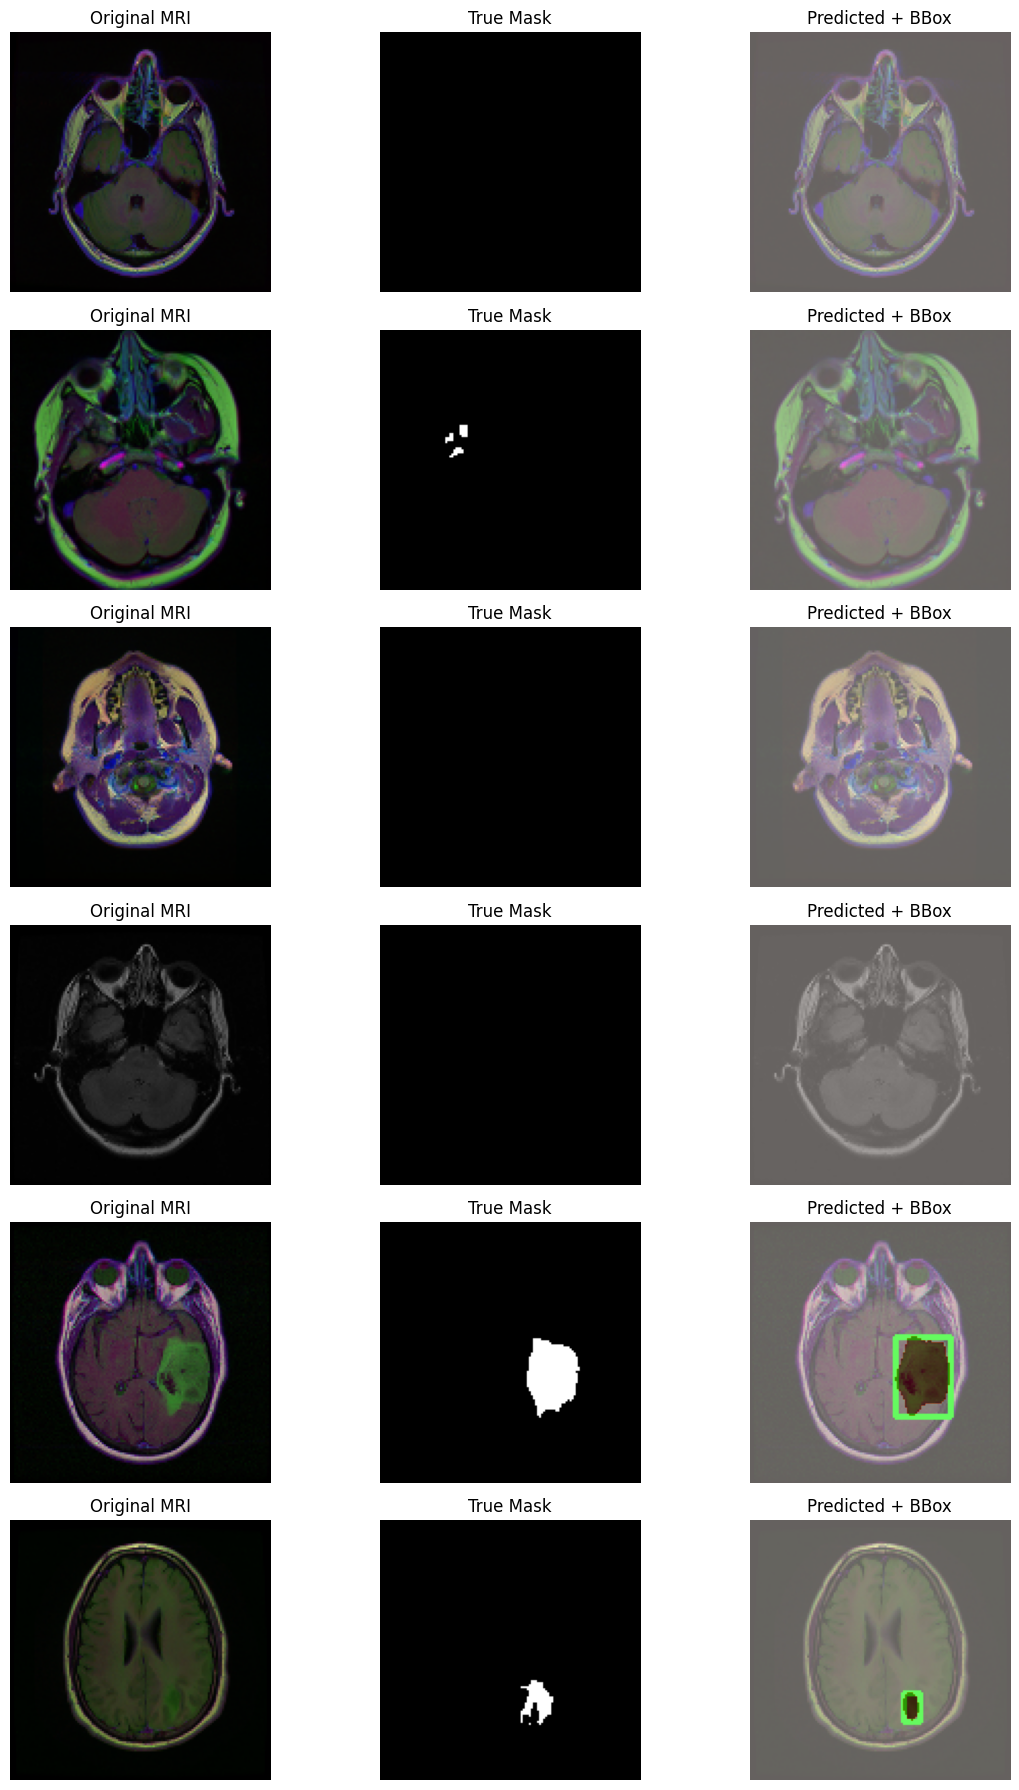

In [24]:
def visualize_with_bbox(model, X_test, y_test, num_samples=5, threshold=0.5):
    """
    Visualize predicted masks and bounding boxes for tumor regions.
    """
    indices = random.sample(range(len(X_test)), num_samples)
    plt.figure(figsize=(12, num_samples * 3))

    for i, idx in enumerate(indices):
        # Get image and true mask
        image = (X_test[idx] * 255).astype(np.uint8)
        true_mask = (y_test[idx].squeeze() * 255).astype(np.uint8)

        # Predict mask
        pred = model.predict(np.expand_dims(X_test[idx], axis=0), verbose=0)[0]
        pred_mask = (pred.squeeze() > threshold).astype(np.uint8) * 255

        # Find contours on predicted mask
        contours, _ = cv2.findContours(pred_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        image_with_bbox = image.copy()

        # Draw bounding boxes
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(image_with_bbox, (x, y), (x+w, y+h), (0, 255, 0), 2)

        # Show image + mask + bbox
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(image)
        plt.title("Original MRI")
        plt.axis("off")

        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(true_mask, cmap="gray")
        plt.title("True Mask")
        plt.axis("off")

        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(image_with_bbox)
        plt.imshow(pred_mask, cmap="Reds", alpha=0.4)
        plt.title("Predicted + BBox")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Run visualization
visualize_with_bbox(model, X_test, y_test, num_samples=6)

## 🔟 **Conclusion**

This project successfully implemented a **U-Net-based deep learning model** for brain tumor segmentation and tumor presence detection from MRI images. The model was trained using data augmentation to improve generalization and evaluated on a held-out test set.

Key outcomes include:

*  **High accuracy** in identifying the presence of tumors (**~88.5%** detection accuracy).
*  **Strong segmentation performance**, with a **Dice Coefficient of 0.68** and **IoU of 0.53**, indicating effective mask prediction and overlap with the ground truth.
*  The **loss curves** and **metric trends** show stable learning and good generalization to unseen data.

### **Insights**

* The model demonstrates reliable tumor localization and segmentation, even in challenging MRI cases.
* Some minor misclassifications occur in images with small or faint tumor regions, suggesting potential improvements through model fine-tuning or enhanced preprocessing.
* The Dice and IoU metrics confirm that the segmentation model captures tumor boundaries with reasonable accuracy.